<a href="https://colab.research.google.com/github/jglaser/gigadocking_notebooks/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np
import pandas as pd
#import os

import matplotlib.pyplot as plt
import seaborn as sns

# Normalizer
from sklearn.preprocessing import Normalizer

# ML classificator
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve 

import xgboost as xgb

#import openbabel 
#import pybel 

## Train BigQuery XGB

In [2]:
project_id = 'cmb-covid19-discovery-collab'

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
%%bigquery --project $project_id df
SELECT * FROM moonshot.mpro_features LIMIT 10

In [5]:
import numpy as np
columns_moonshot = sorted([c for c in df.columns if c != 'string_field_0' and c.split('_')[-1] != 'tr'], key=lambda x: int(x.split('_')[1]))
columns_moonshot_tr = sorted([c for c in df.columns if c != 'string_field_0'], key=lambda x: int(x.split('_')[1]))


In [ ]:
q = "SELECT activities.f_avg_IC50,"+','.join(columns_moonshot) + \
f""" FROM moonshot.mpro_features
INNER JOIN moonshot.activities
ON activities.CID = mpro_features.string_field_0
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_features = client.query(q).to_dataframe()

In [ ]:
X = df_features[ columns_moonshot ]
y = df_features['f_avg_IC50'] < 5. 

param_dist = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

from sklearn.metrics import make_scorer

def my_scorer(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:,1]
    p, r, _ = precision_recall_curve(y_true, y_pred_proba)
    auc = np.trapz(p[::-1],r[::-1])
    return auc

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)
# custom scoring function doesn't work with n_jobs = -1
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 100, scoring = my_scorer, error_score = 'raise', verbose=1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
scores = []
y_real = []
y_proba = []
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    y_real.append(y_test)
    y_proba.append(pred_proba[:,1])
    #score += f1_score(y_test, results[test_index])
    scores.append(my_scorer(clf.best_estimator_,X_test,y_test))

# train on entire data set
clf.fit(X,y)
model_notr = clf.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   56.5s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   59.8s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   57.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   53.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   59.1s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.1min finished


In [30]:
q = "SELECT activities.f_avg_IC50,"+','.join(columns_moonshot_tr) + \
f""",string_field_0 AS CID FROM moonshot.mpro_features
INNER JOIN moonshot.activities
ON activities.CID = mpro_features.string_field_0
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_features_tr = client.query(q).to_dataframe()

In [ ]:
X = df_features_tr[ columns_moonshot_tr ]
y = df_features_tr['f_avg_IC50'] < 5. 

param_dist = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

def my_scorer(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:,1]
    p, r, _ = precision_recall_curve(y_true, y_pred_proba)
    auc = np.trapz(p[::-1],r[::-1])
    return auc

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)
# custom scoring function doesn't work with n_jobs = -1
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 100, scoring = my_scorer, error_score = 'raise', verbose=1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators_tr = []
results = np.zeros(len(X))
scores_tr = []
y_real_tr = []
y_proba_tr = []
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators_tr.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    y_real_tr.append(y_test)
    y_proba_tr.append(pred_proba[:,1])
    #score_tr += f1_score(y_test, results[test_index])
    scores_tr.append(my_scorer(clf.best_estimator_,X_test,y_test))

# train on entire data set
clf.fit(X,y)
model_tr = clf.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


[]

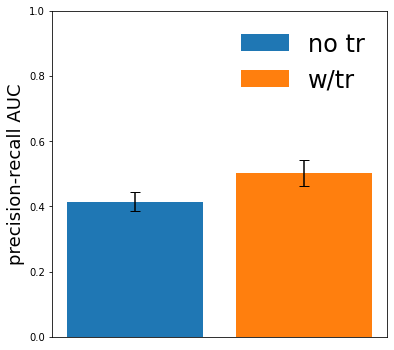

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
x = [np.mean(scores), np.mean(scores_tr)]
ax.bar([0],[x[0]],width=0.4,label='no tr',yerr=np.std(scores)/np.sqrt(len(scores)),capsize=5)
ax.bar([0.5],[x[1]],width=0.4,label='w/tr',yerr=np.std(scores_tr)/np.sqrt(len(scores_tr)),capsize=5)
ax.set_ylim(0,1)
ax.legend(frameon=False,fontsize=24)
ax.set_ylabel('precision-recall AUC',fontsize=18)
ax.set_xticks([])

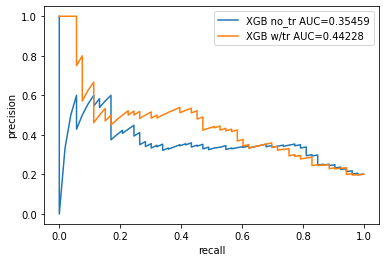

In [ ]:
fig = plt.figure()
ax = fig.subplots()

yreal = np.concatenate(y_real)
yproba = np.concatenate(y_proba)
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB no_tr AUC={:.5f}'.format(auc))


yreal = np.concatenate(y_real_tr)
yproba = np.concatenate(y_proba_tr)
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB w/tr AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend()
plt.show()
#fig.savefig('AUC_test.png')

In [ ]:
model = model_tr
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5255383009693526, gamma=0,
              learning_rate=0.061658177798448524, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=253, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8779782890904051,
              use_label_encoder=False, verbosity=1)

In [ ]:
active_uM = 5.0
f_str = ','.join(columns_moonshot_tr)
q = f"""
CREATE OR REPLACE MODEL moonshot.xgbmodel
OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
        DATA_SPLIT_METHOD = 'NO_SPLIT',
        BOOSTER_TYPE = '{model.booster}',
        MIN_TREE_CHILD_WEIGHT = {model.min_child_weight},
        MAX_TREE_DEPTH = {model.max_depth},
        MIN_SPLIT_LOSS={model.gamma},
        NUM_PARALLEL_TREE = 1,
        LEARN_RATE={model.learning_rate},
        MAX_ITERATIONS = {model.n_estimators},
        TREE_METHOD = 'AUTO',
        EARLY_STOP = FALSE,
        SUBSAMPLE = {model.subsample},
        COLSAMPLE_BYTREE = {model.colsample_bytree},
        INPUT_LABEL_COLS = ['active'])
AS SELECT (f_avg_IC50 < {active_uM}) AS active,
          {f_str}
FROM moonshot.mpro_features
INNER JOIN moonshot.activities
ON activities.CID = mpro_features.string_field_0
WHERE f_avg_IC50 IS NOT NULL
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
client.query(q).to_dataframe()

""


In [ ]:
feat = pd.DataFrame(model.feature_importances_, index=columns_moonshot_tr, columns=['importance'])
with pd.option_context('display.max_rows', None):  # more options can be specified also
    print(feat.sort_values(by='importance', ascending=False))

            importance
SER_144_PB    0.079609
THR_25_AB     0.069595
SER_144_tr    0.065462
CYS_145_PB    0.058191
ASN_142_AB    0.056008
CYS_145_tr    0.049868
HSD_41_PB     0.039649
GLN_189_AB    0.037348
ASP_187_AB    0.037216
ARG_188_PB    0.037068
GLN_189_PB    0.034200
GLU_166_AB    0.033462
MET_165_AB    0.031400
ASN_142_tr    0.030791
PHE_140_PB    0.030230
HSE_164_PB    0.030139
HSD_41_AB     0.029566
MET_49_AB     0.028417
ASP_187_PB    0.027566
CYS_44_PB     0.026704
GLY_143_PB    0.025147
ASN_142_PB    0.024672
GLU_166_PB    0.024547
TYR_54_PB     0.023374
THR_190_PB    0.022377
GLU_166_tr    0.020410
MET_165_PB    0.018655
THR_25_PB     0.008331
ASN_119_AB    0.000000
ASP_187_tr    0.000000
LEU_167_AB    0.000000
LEU_167_tr    0.000000
PRO_168_PB    0.000000
PRO_168_AB    0.000000
PRO_168_tr    0.000000
HSE_172_PB    0.000000
HSE_172_AB    0.000000
HSE_172_tr    0.000000
PHE_185_PB    0.000000
PHE_185_AB    0.000000
PHE_185_tr    0.000000
LEU_27_AB     0.000000
LEU_27_PB  

In [ ]:
%%bigquery --project $project_id df_exp
SELECT A.*, exp.__residual_activity FROM mpro_5r84.mpro_features_new AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)

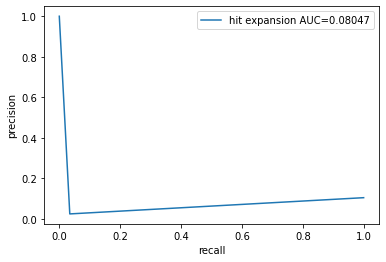

In [ ]:
y_real_exp = df_xgboost.__residual_activity < .25
y_proba_exp = model_tr.predict(df_exp[columns_moonshot_tr])

fig = plt.figure()
ax = fig.subplots()

p, r, _ = precision_recall_curve(y_real_exp, y_proba_exp)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='hit expansion AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend()
plt.show()
#fig.savefig('AUC_test.png')

In [ ]:
%%bigquery --project $project_id df_xgboost
SELECT enamine_id, AVG(__residual_activity) as residual_activity, AVG(predicted_active_probs[OFFSET(0)].prob) AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, exp.__residual_activity, exp.Inhibitor as enamine_id FROM mpro_5r84.mpro_features_new AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)))
GROUP BY enamine_id
ORDER BY xgb_score DESC

In [ ]:
df_xgboost.sort_values(by='residual_activity')

,enamine_id,residual_activity,xgb_score
85,Z1530718726,0.09,0.016973
46,Z1530724963,0.09,0.144322
78,Z1530724813,0.10,0.031390
12,Z1530725178,0.10,0.414585
36,Z1927517858,0.10,0.200490
...,...,...,...
18,PV-001922393904,1.02,0.308011
5,Z2255124682,1.07,0.506311
52,Z1427837125,1.09,0.123641
62,Z2101329443,1.11,0.102842


In [ ]:
model_tr.predict_proba(df_features_tr[df_features_tr.CID.str.startswith('ADA-UCB-6c2cb422-1')][columns_moonshot_tr])

array([[0.30830932, 0.6916907 ]], dtype=float32)

(array([144.,  63.,  13.,  10.,   5.,  11.,  11.,  11.,   5.,   4.]),
 array([0.00872679, 0.10338567, 0.19804455, 0.29270342, 0.3873623 ,
        0.48202118, 0.57668006, 0.671339  , 0.7659978 , 0.86065674,
        0.9553156 ], dtype=float32),
 <a list of 10 Patch objects>)

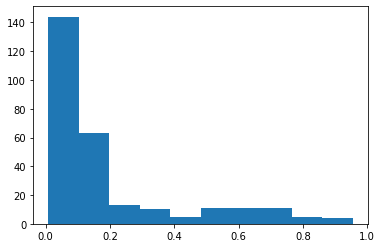

In [ ]:
fig, ax = plt.subplots()
ax.hist(model_tr.predict_proba(df_features_tr[columns_moonshot_tr])[:,1])

In [ ]:
df_exp[df_exp.name.str.startswith('Z1530724813')][columns_moonshot_tr].to_numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 5., 0., 3., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 2., 0., 0., 0., 0.,
        3., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 5., 0., 3., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 2., 0., 0., 0., 0.,
        3., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
tmp=df_exp[df_exp.name.str.startswith('Z1530724813')].iloc[0][columns_moonshot_tr]
tmp[tmp>0]

HSD_41_AB     2
MET_49_PB     1
TYR_54_PB     2
HSE_164_PB    1
MET_165_AB    5
GLU_166_PB    3
LEU_167_AB    1
PRO_168_AB    1
ASP_187_PB    2
ASP_187_AB    2
ARG_188_PB    2
GLN_189_tr    3
THR_190_PB    3
Name: 253, dtype: object

In [ ]:
tmp=df_features_tr[df_features_tr.CID.str.startswith('ADA-UCB-6c2cb422-1')][columns_moonshot_tr].iloc[0]
tmp[tmp>0]

ASN_142_AB    2.0
SER_144_PB    1.0
SER_144_tr    1.0
HSE_164_PB    2.0
GLU_166_PB    2.0
GLU_166_AB    1.0
Name: 50, dtype: float64

In [ ]:
model_tr.predict_proba(df_exp[df_exp.name.startswith('Z1530724813')][columns_moonshot_tr])

array([[0.96433955, 0.03566047],
       [0.96433955, 0.03566047],
       [0.96433955, 0.03566047],
       [0.96433955, 0.03566047]], dtype=float32)

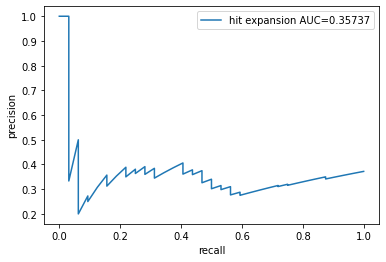

In [ ]:
fig = plt.figure()
ax = fig.subplots()

yreal = df_xgboost.residual_activity < .25
yproba = df_xgboost.xgb_score
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='hit expansion AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend()
plt.show()
#fig.savefig('AUC_test.png')

In [ ]:
%%bigquery --project $project_id df_xgboost_all
SELECT enamine_id, __residual_activity as residual_activity, predicted_active_probs[OFFSET(0)].prob AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, exp.__residual_activity, exp.Inhibitor as enamine_id FROM mpro_5r84.mpro_features_new_all AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)))
ORDER BY xgb_score DESC

In [ ]:
df_xgboost_all_grouped = df_xgboost_all.groupby('enamine_id').max('xgb_score').reset_index()

In [ ]:
df_xgboost_all_grouped.sort_values(by='xgb_score',ascending=False)

,enamine_id,residual_activity,xgb_score
12,Z2958605212,0.51,0.991497
10,Z18886707,0.43,0.971465
0,PV-001947954016,0.47,0.971294
1,Z1083297490,0.58,0.964839
7,Z1530800272,0.31,0.954117
5,Z1530717425,0.59,0.938127
8,Z1743649707,0.38,0.898928
3,Z1426602181,1.14,0.881180
9,Z1832772406,0.55,0.879408
11,Z2101329443,1.11,0.822674


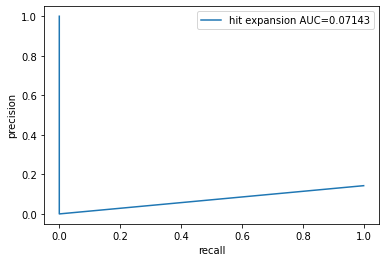

In [ ]:
fig = plt.figure()
ax = fig.subplots()

yreal = df_xgboost_all_grouped.residual_activity < .25
yproba = df_xgboost_all_grouped.xgb_score
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='hit expansion AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend()
plt.show()

In [43]:
%%bigquery --project $project_id df_rf3
SELECT Inhibitor AS enamine_id, __residual_activity as residual_activity, rf3
FROM mpro_5r84.scores_rank0 AS A
INNER JOIN mpro_exp.hit_expansion AS exp
ON STARTS_WITH(A.name,exp.Inhibitor)

In [63]:
df_rf3_grouped = df_rf3.groupby('enamine_id').mean('rf3').reset_index()

In [52]:
%%bigquery --project $project_id df_rf2
SELECT Inhibitor AS enamine_id, __residual_activity as residual_activity, rf2, dcoid, vs_dude_v2
FROM mpro_5r84.scores AS A
INNER JOIN mpro_exp.hit_expansion AS exp
ON STARTS_WITH(A.name,exp.Inhibitor)

In [64]:
df_rf2_grouped = df_rf2.groupby('enamine_id').mean(['rf2','dcoid','vs_dude_v2']).reset_index()

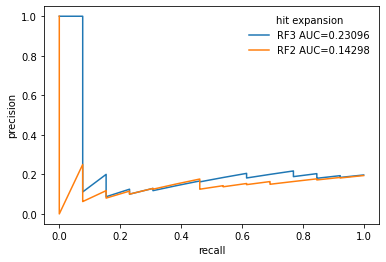

In [68]:
fig = plt.figure()
ax = fig.subplots()

yreal = df_rf3_grouped.residual_activity < .25
yproba = df_rf3_grouped.rf3
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='RF3 AUC={:.5f}'.format(auc))


yreal = df_rf2_grouped.residual_activity < .25
yproba = df_rf2_grouped.rf2
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='RF2 AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend(frameon=False,title='hit expansion')
plt.show()

## Train on RF2 descriptors

In [73]:
q = """SELECT activities.f_avg_IC50, diamond_descriptors_v2.*
FROM moonshot.diamond_descriptors_v2
INNER JOIN moonshot.activities
ON activities.frag_id = diamond_descriptors_v2.name
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_rf2_features = client.query(q).to_dataframe()

In [86]:
len(df_rf2_features)

212

In [76]:
columns_rf2 = [c for c in df_rf2_features.columns if c != 'name' and c != 'f_avg_IC50']

In [79]:
X = df_rf2_features[ columns_rf2 ]
y = df_rf2_features['f_avg_IC50'] < 5. 

param_dist = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

from sklearn.metrics import make_scorer

def my_scorer(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:,1]
    p, r, _ = precision_recall_curve(y_true, y_pred_proba)
    auc = np.trapz(p[::-1],r[::-1])
    return auc

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)
# custom scoring function doesn't work with n_jobs = -1
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 100, scoring = my_scorer, error_score = 'raise', verbose=1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
scores = []
y_real = []
y_proba = []
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    y_real.append(y_test)
    y_proba.append(pred_proba[:,1])
    #score += f1_score(y_test, results[test_index])
    scores.append(my_scorer(clf.best_estimator_,X_test,y_test))

# train on entire data set
clf.fit(X,y)
model_rf2 = clf.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.2min finished


(array([121.,  45.,   9.,   5.,   6.,  11.,   4.,   6.,   0.,   5.]),
 array([0.00615863, 0.10069826, 0.19523789, 0.28977752, 0.38431713,
        0.47885677, 0.5733964 , 0.667936  , 0.76247567, 0.85701525,
        0.9515549 ], dtype=float32),
 <a list of 10 Patch objects>)

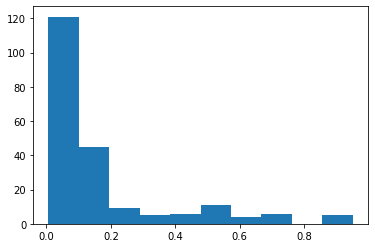

In [132]:
fig, ax = plt.subplots()
ax.hist(np.concatenate(y_proba))

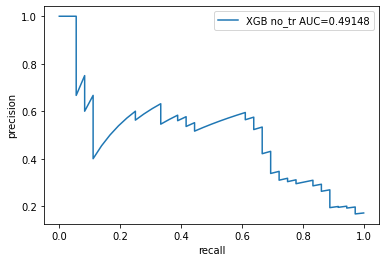

In [84]:
fig = plt.figure()
ax = fig.subplots()

yreal = np.concatenate(y_real)
yproba = np.concatenate(y_proba)
p, r, _ = precision_recall_curve(yreal, yproba)

auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB no_tr AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend()
plt.show()
#fig.savefig('AUC_test.png')

In [134]:
model = model_rf2
active_uM = 5.0
f_str = ','.join(columns_rf2)
#DATA_SPLIT_METHOD = 'NO_SPLIT',
q = f"""
CREATE OR REPLACE MODEL moonshot.xgbmodel_rf2
OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',       
        BOOSTER_TYPE = '{model.booster}',
        MIN_TREE_CHILD_WEIGHT = {model.min_child_weight},
        MAX_TREE_DEPTH = {model.max_depth},
        MIN_SPLIT_LOSS={model.gamma},
        NUM_PARALLEL_TREE = 1,
        LEARN_RATE={model.learning_rate},
        MAX_ITERATIONS = {model.n_estimators},
        TREE_METHOD = 'AUTO',
        EARLY_STOP = FALSE,
        SUBSAMPLE = {model.subsample},
        COLSAMPLE_BYTREE = {model.colsample_bytree},
        INPUT_LABEL_COLS = ['active'])
AS SELECT (f_avg_IC50 < {active_uM}) AS active,
          {f_str}
FROM moonshot.diamond_descriptors_v2
INNER JOIN moonshot.activities
ON activities.frag_id = diamond_descriptors_v2.name
WHERE f_avg_IC50 IS NOT NULL
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
client.query(q).to_dataframe()

""


In [243]:
%%bigquery --project $project_id df_xgboost_rf2
SELECT enamine_id, rank, __residual_activity as residual_activity, predicted_active_probs[OFFSET(0)].prob AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel_rf2`,
  (SELECT A.*, exp.__residual_activity, exp.Inhibitor as enamine_id FROM mpro_5r84.rf2_descriptors AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)))
ORDER BY xgb_score DESC

In [321]:
#df_xgboost_rf2_grouped = df_xgboost_rf2.groupby(['enamine_id','residual_activity']).max(['xgb_score']).reset_index()
#df_xgboost_rf2_grouped = df_xgboost_rf2.groupby(['enamine_id','residual_activity']).apply(
#    lambda x: x.sort_values(by='rank').head(1)).reset_index(drop=True)
df_xgboost_rf2_grouped = df_xgboost_rf2.groupby(['enamine_id','residual_activity']).apply(
    lambda x: x.sort_values(by='xgb_score',ascending=True).reset_index(drop=True).iloc[0]).reset_index(drop=True)

In [322]:
df_xgboost_rf2_grouped.sort_values(by='xgb_score',ascending=False)

,enamine_id,rank,residual_activity,xgb_score
50,Z1593752786,15,0.70,0.383911
1,PV-001801306793,10,0.42,0.298979
38,Z1530791178,11,0.90,0.289642
59,Z1743649707,17,0.38,0.285384
53,Z1651778988,10,0.55,0.284260
...,...,...,...,...
81,Z243430052,19,0.48,0.095983
41,Z1530800067,9,0.68,0.094954
74,Z2077732466,2,0.90,0.091641
11,Z1096224331,13,0.42,0.086849


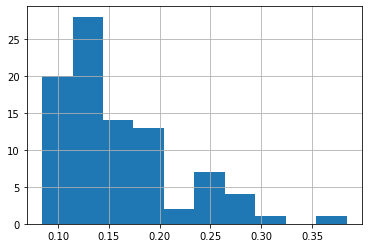

In [323]:
df_xgboost_rf2_grouped['xgb_score'].hist()

In [1]:
fig = plt.figure()
ax = fig.subplots()

yreal = df_xgboost_rf2_grouped.residual_activity < .25
yproba = df_xgboost_rf2_grouped.xgb_score
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='RF3 AUC={:.5f}'.format(auc))


ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend(frameon=False,title='hit expansion')
plt.show()

NameError: ignored

In [135]:
%%bigquery --project $project_id df_exp_rf2
SELECT A.*, exp.__residual_activity FROM mpro_5r84.rf2_descriptors AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)

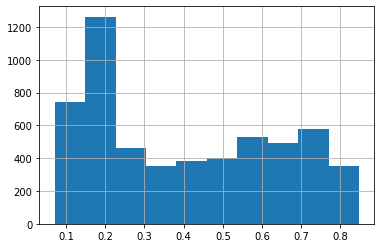

In [188]:
df_exp_rf2['proba'] = model_rf2.predict_proba(df_exp_rf2[columns_rf2])[:,1]
df_exp_rf2['proba'].hist()
df_exp_rf2['enamine_id'] = df_exp_rf2['name'].str.split('_').str[0]

In [297]:
df_exp_rf2_grouped = df_exp_rf2.groupby(['enamine_id','__residual_activity']).apply(
    lambda x: x.sort_values(by='score',ascending=True).iloc[10]).reset_index(drop=True)

In [298]:
df_exp_rf2_grouped

,desc_v2_0,desc_v2_1,desc_v2_2,desc_v2_3,desc_v2_4,desc_v2_5,desc_v2_6,desc_v2_7,desc_v2_8,desc_v2_9,desc_v2_10,desc_v2_11,desc_v2_12,desc_v2_13,desc_v2_14,desc_v2_15,desc_v2_16,desc_v2_17,desc_v2_18,desc_v2_19,desc_v2_20,desc_v2_21,desc_v2_22,desc_v2_23,desc_v2_24,desc_v2_25,desc_v2_26,desc_v2_27,desc_v2_28,desc_v2_29,desc_v2_30,desc_v2_31,desc_v2_32,desc_v2_33,desc_v2_34,desc_v2_35,desc_v2_36,desc_v2_37,desc_v2_38,desc_v2_39,...,desc_v2_182,desc_v2_183,desc_v2_184,desc_v2_185,desc_v2_186,desc_v2_187,desc_v2_188,desc_v2_189,desc_v2_190,desc_v2_191,desc_v2_192,desc_v2_193,desc_v2_194,desc_v2_195,desc_v2_196,desc_v2_197,desc_v2_198,desc_v2_199,desc_v2_200,desc_v2_201,desc_v2_202,desc_v2_203,desc_v2_204,desc_v2_205,desc_v2_206,desc_v2_207,desc_v2_208,desc_v2_209,desc_v2_210,desc_v2_211,desc_v2_212,desc_v2_213,desc_v2_214,desc_v2_215,rank,score,name,__residual_activity,proba,enamine_id
0,0,25,255,479,877,1369,0,14,84,162,251,382,0,18,78,156,252,387,0,1,24,19,19,15,0,7,31,60,94,150,0,1,12,22,26,36,0,5,6,20,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-9.07,PV-001792285514_2_T1,0.50,0.496388,PV-001792285514
1,0,51,276,431,688,959,0,28,102,134,205,266,0,17,70,141,183,250,0,6,7,9,28,20,0,3,18,54,72,112,0,2,14,9,27,33,0,2,5,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,-9.95,PV-001801306793_2_T1,0.42,0.235750,PV-001801306793
2,0,32,251,403,685,1150,0,21,80,134,215,286,0,34,71,142,207,323,0,1,10,17,18,19,0,3,22,25,81,105,0,1,7,15,23,29,0,1,8,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,-8.96,PV-001841410851_2_T1,0.67,0.191668,PV-001841410851
3,0,31,273,485,883,1381,0,15,86,167,255,386,0,20,77,162,272,378,0,4,18,24,17,19,0,4,44,90,117,220,0,3,17,26,42,59,0,3,14,26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,-8.71,PV-001922393904_1_T1,1.02,0.559758,PV-001922393904
4,0,39,314,549,998,1378,0,24,104,162,290,416,0,24,79,188,268,451,0,12,14,20,23,29,0,1,32,76,126,248,0,2,14,22,39,73,0,1,12,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,-9.12,PV-001947954016_2_T1,0.47,0.447341,PV-001947954016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0,38,302,549,1015,1505,0,12,111,183,305,389,0,25,93,181,281,445,0,4,23,23,21,17,0,3,7,26,56,71,0,1,3,9,19,11,0,1,4,8,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-9.68,Z2717603243_7_T1,0.88,0.816337,Z2717603243
105,0,45,256,515,927,1445,0,21,74,189,296,360,0,21,75,170,294,438,0,2,23,19,15,34,0,7,39,83,143,216,0,2,14,33,40,50,0,3,15,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,-9.11,Z2958605212_2_T1,0.51,0.748594,Z2958605212
106,0,24,241,468,896,1336,0,12,78,158,286,360,0,7,70,153,261,413,0,6,22,20,15,27,0,4,31,80,112,211,0,0,13,25,38,59,0,2,11,23,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,-7.83,Z3204113440_1_T2,0.69,0.704109,Z3204113440
107,0,31,246,432,719,1118,0,17,88,134,216,304,0,31,65,151,206,312,0,1,14,14,21,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-8.21,Z358982816_1_T2,0.81,0.199940,Z358982816


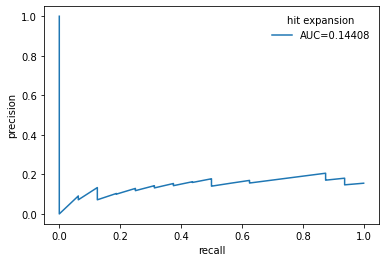

In [299]:
yr = df_exp_rf2_grouped.__residual_activity < 0.25
p, r, _ = precision_recall_curve(yr, df_exp_rf2_grouped.proba)
auc = np.trapz(p[::-1],r[::-1])
fig, ax = plt.subplots()
ax.plot(r,p,label='AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend(frameon=False,title='hit expansion')

### Compare Vina vs AD GPU

In [78]:
%%bigquery --project $project_id df_xgboost_vina
SELECT name, AVG(f_avg_IC50) AS f_avg_IC50, MIN(predicted_active_probs[OFFSET(0)].prob) AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, f_avg_IC50 FROM moonshot.mpro_features_vina AS A
   INNER JOIN moonshot.activities AS activities
   ON STARTS_WITH(A.name,activities.CID)))
GROUP BY name
ORDER BY xgb_score DESC

In [79]:
%%bigquery --project $project_id df_xgboost_adgpu
SELECT name, AVG(f_avg_IC50) as f_avg_IC50, MIN(predicted_active_probs[OFFSET(0)].prob) AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, f_avg_IC50 FROM moonshot.mpro_features_redocked_5R84_01 AS A
   INNER JOIN moonshot.activities AS activities
   ON STARTS_WITH(A.name,activities.CID)))
GROUP BY name
ORDER BY xgb_score DESC


In [76]:
%%bigquery --project $project_id df_xgboost_diamond
SELECT string_field_0 AS name, f_avg_IC50, predicted_active_probs[OFFSET(0)].prob AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, f_avg_IC50 FROM moonshot.mpro_features AS A
   INNER JOIN moonshot.activities AS activities
   ON STARTS_WITH(A.string_field_0,activities.CID)))
ORDER BY xgb_score DESC


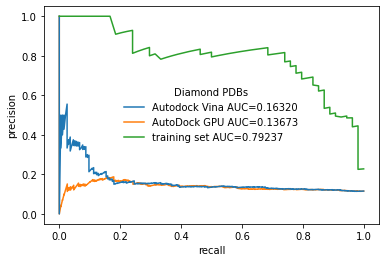

In [80]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
thresh = 5
yr = df_xgboost_vina.f_avg_IC50 < thresh
p, r, _ = precision_recall_curve(yr, df_xgboost_vina.xgb_score)
auc = np.trapz(p[::-1],r[::-1])
fig, ax = plt.subplots()
ax.plot(r,p,label='Autodock Vina AUC={:.5f}'.format(auc),zorder=1)


yr = df_xgboost_adgpu.f_avg_IC50 < thresh
p, r, _ = precision_recall_curve(yr, df_xgboost_adgpu.xgb_score)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='AutoDock GPU AUC={:.5f}'.format(auc),zorder=0)

yr = df_xgboost_diamond.f_avg_IC50 < thresh
p, r, _ = precision_recall_curve(yr, df_xgboost_diamond.xgb_score)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='training set AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend(frameon=False,title='Diamond PDBs')
fig.savefig('auc_min.pdf')

In [70]:
from google.colab import files
files.download('auc_min.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>